# News classification with topic models in gensim
News article classification is a task which is performed on a huge scale by news agencies all over the world. We will be looking into how topic modeling can be used to accurately classify news articles into different categories such as sports, technology, politics etc.

Our aim in this tutorial is to come up with some topic model which can come up with topics that can easily be interpreted by us. Such a topic model can be used to discover hidden structure in the corpus and can also be used to determine the membership of a news article into one of the topics.

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001.

Accompanying slides can be found [here](https://speakerdeck.com/dsquareindia/pycon-delhi-lightening).

### Requirements
In this tutorial we look at how different topic models can be easily created using [gensim](https://radimrehurek.com/gensim/).
Following are the dependencies for this tutorial:
    - Gensim Version >=0.13.1 would be preferred since we will be using topic coherence metrics extensively here.
    - matplotlib
    - nltk.stopwords and nltk.wordnet
    - pyLDAVis
We will be playing around with 4 different topic models here:
    - LSI (Latent Semantic Indexing)
    - HDP (Hierarchical Dirichlet Process)
    - LDA (Latent Dirichlet Allocation)
    - LDA (tweaked with topic coherence to find optimal number of topics) and
    - LDA as LSI with the help of topic coherence metrics
First we'll fit those topic models on our existing data then we'll compare each against the other and see how they rank in terms of human interpretability.

All can be found in gensim and can be easily used in a plug-and-play fashion. We will tinker with the LDA model using the newly added topic coherence metrics in gensim based on [this](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) paper by Roeder et al and see how the resulting topic model compares with the exsisting ones.

In [1]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

import nltk
nltk.download('stopwords') # Let's make sure the 'stopword' package is downloaded & updated
nltk.download('wordnet') # Let's also download wordnet, which will be used for lemmatization

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

import numpy as np
import pandas as pd

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [65]:
# df = pd.read_csv('../data/rss_feeds_new.csv')
# df = df[pd.notnull(df['processed_text'])]
# text = df['processed_text'].values.tolist()
df = pd.read_csv('../data/rss_feeds_new.csv')
df = df[pd.notnull(df['article_text'])]
text = df['article_text'].values.tolist()

### Data Exploration

In [55]:
def get_article_length_hist(df):
    site_article_length = {source: [] for source in df['source'].unique()}
    for source in df['source'].unique():
        new_df = df[df['source'] == source]
        for article in new_df['article_text']:
            site_article_length[source].append(len(article.split()))


    for i, source in enumerate(site_article_length.keys()):
        plt.subplot(4,3,i+1)
        plt.hist(site_article_length[source], normed=True)
        plt.title('Article Length '+source)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

Populating the interactive namespace from numpy and matplotlib


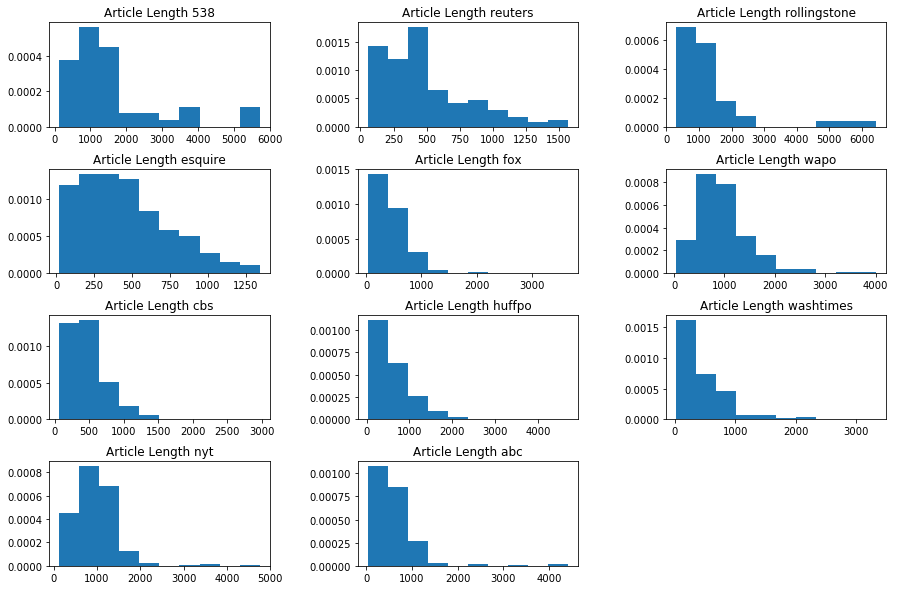

In [56]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

get_article_length_hist(df)

In [58]:
def build_texts(text):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    for line in text:
        yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

In [68]:
train_texts = list(build_texts(text))

In [69]:
len(train_texts)

3551

### The following gets a summaries of the articles that are inserted

In [60]:
from gensim.summarization import summarize
from gensim.summarization import keywords

In [61]:
def get_summaries(df):
    summary = []
    for article in df['article_text']:
        try:
            summary.append(summarize(article))
        except:
            summary.append('')
    
    return summary

In [62]:
summary = get_summaries(df)
print(summary[0])

When the original American Health Care Act failed in March (it was not put to a vote because the GOP’s internal counts showed it would have been rejected), there was a bloc of more moderate GOP members who opposed it as being too stingy in terms of covering people and lowering costs for the elderly and poor.
It seemed like House Speaker Paul Ryan was in a Catch-22: Any changes to the bill that would appeal to the Freedom Caucus would cause additional defections among the more moderate members.
They didn’t demand that the House, before voting, wait for the Congressional Budget Office to review the new provisions, even as experts correctly predicted that the CBO, when given time to complete an analysis, would conclude that the changes to the bill would not be that helpful to those with pre-existing conditions or low-income elderly people.
Six Republican senators, including five from the 31 states that have expanded Medicaid, have been suggesting for months that the Republican health care

### Preprocessing our data. Remember: Garbage In Garbage Out
                                        "NLP is 80% preprocessing."
                                                                -Lev Konstantinovskiy
This is the single most important step in setting up a good topic modeling system. If the preprocessing is not good, the algorithm can't do much since we would be feeding it a lot of noise. In this tutorial, we will be filtering out the noise using the following steps in this order for each line:
1. Stopword removal using NLTK's english stopwords dataset.
2. Bigram collocation detection (frequently co-occuring tokens) using gensim's [Phrases](https://radimrehurek.com/gensim/models/phrases.html). This is our first attempt to find some hidden structure in the corpus. You can even try trigram collocation detection.
3. Lemmatization (using gensim's [`lemmatize`](https://radimrehurek.com/gensim/utils.html#gensim.utils.lemmatize)) to only keep the nouns. Lemmatization is generally better than stemming in the case of topic modeling since the words after lemmatization still remain understable. However, generally stemming might be preferred if the data is being fed into a vectorizer and isn't intended to be viewed.

In [70]:
bigram = gensim.models.Phrases(train_texts)  # for bigram collocation detection
trigram = gensim.models.Phrases(bigram[train_texts])  # for trigram collocation detection

In [72]:
print(bigram[['the', 'new', 'york','times', 'example']])
print(trigram[bigram[['the', 'new', 'york','times', 'example']]])

['the', 'new_york', 'times', 'example']
['the', 'new_york_times', 'example']


In [73]:
from gensim.utils import lemmatize
from nltk.corpus import stopwords

In [74]:
stops = set(stopwords.words('english'))  # nltk stopwords list
words_to_remove = ['http', 'com', '_', '__', '___', 'mr']

In [78]:
def process_texts(headline_text, article_text):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
#     article_text = [[word for word in line if word not in stops] for line in article_text]
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    article_quotes1 = ' '.join(re.findall('“.*?”', article_text))
    article_quotes2 = ' '.join(re.findall('".*?"', article_text))
    headline_quotes1 = ' '.join(re.findall('“.*?”', headline_text))
    headline_quotes2 = ' '.join(re.findall('".*?"', headline_text))
    quotes = article_quotes1 + article_quotes2 + headline_quotes1 + headline_quotes2

    tweets = ' '.join(re.findall('\n\n.*?@', article_text))+' '+' '.join(re.findall('\n\n@.*?@', article_text))

    article_text = re.sub('\n\n.*?@', '', article_text)
    article_text = re.sub('\n\n@.*?@', '', article_text)
    headline_text = re.sub('\n\n.*?@', '', headline_text)
    headline_text = re.sub('\n\n@.*?@', '', headline_text)
    # Remove tweet
    article_text = ' '.join([word for word in article_text.split(' ') if not word.startswith('(@') and not word.startswith('http')])

    article_text = re.sub('“.*?”', '', article_text)
    article_text = re.sub('".*?"', '', article_text)

    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    sw = set(stopwords.words('english'))
    wordnet = WordNetLemmatizer()

    article_text = article_text.lower()
    headline_text = headline_text.lower()
    quotes = quotes.lower()
    tweets = tweets.lower()

    article_text_tokens = tokenizer.tokenize(article_text)
    headline_text_tokens = tokenizer.tokenize(headline_text)
    quotes_tokens = tokenizer.tokenize(quotes)
    tweets_tokens = tokenizer.tokenize(tweets)

    # remove stop words, unwanted words, tweet handles, links from tokens
    article_text_stopped_tokens = [i for i in article_text_tokens if i not in sw and i not in words_to_remove]
    headline_text_stopped_tokens = [i for i in headline_text_tokens if i not in sw and i not in words_to_remove]
    quotes_stopped_tokens = [i for i in quotes_tokens if not i in sw and i not in words_to_remove]
    tweets_stopped_tokens = [i for i in tweets_tokens if not i in sw and i not in words_to_remove]

    article_text_stopped_tokens = bigram[article_text_stopped_tokens]
    headline_text_stopped_tokens = bigram[headline_text_stopped_tokens]
    quotes_stopped_tokens = bigram[quotes_stopped_tokens]
    tweets_stopped_tokens = bigram[tweets_stopped_tokens]
    
    article_text_stopped_tokens = trigram[bigram[article_text_stopped_tokens]]
    headline_text_stopped_tokens = trigram[bigram[headline_text_stopped_tokens]]
    quotes_stopped_tokens = trigram[bigram[quotes_stopped_tokens]]
    tweets_stopped_tokens = trigram[bigram[tweets_stopped_tokens]]
    
    # stem token
    article_text = [wordnet.lemmatize(i) for i in article_text_stopped_tokens]
    headline_text = [wordnet.lemmatize(i) for i in headline_text_stopped_tokens]
    quotes = [wordnet.lemmatize(i) for i in quotes_stopped_tokens]
    tweets = [wordnet.lemmatize(i) for i in tweets_stopped_tokens]

    return headline_text, article_text, quotes, tweets

In [80]:
train_texts = []
sentiment_texts = []
for headline, article in zip(df['headline'].tolist(), df['article_text'].tolist()):
    temp = process_texts(headline, article)
    train_texts.append(temp[0] + temp[1] + temp[2] + temp[3])
    sentiment_texts.append(temp[0] + temp[1])
train_texts[5:6]

[['latino',
  'three',
  'city',
  'reporting',
  'fewer',
  'crime',
  'since',
  'trump_took_office',
  'latino',
  'several',
  'big',
  'cities_across',
  'country',
  'appear',
  'reporting',
  'fewer',
  'crime',
  'year',
  'last',
  'pattern',
  'experts_say',
  'could',
  'evidence',
  'president_trump',
  'tough',
  'stance',
  'immigration',
  'sowing',
  'mistrust',
  'law_enforcement_officers',
  'among',
  'immigrant',
  'family',
  'recent_months',
  'police_chief',
  'los_angeles',
  'houston',
  'said',
  'report',
  'latino',
  'certain',
  'type',
  'crime',
  'respective',
  'city',
  'chief',
  'blamed',
  'decline',
  'heightened',
  'fear',
  'deportation',
  'among',
  'undocumented_immigrants',
  'majority',
  'latino',
  'say',
  'trend',
  'concerning',
  'police_department',
  'rely',
  'member',
  'community',
  'regardless',
  'legal_status',
  'report_crimes',
  'occur',
  'houston',
  'police_chief',
  'art',
  'acevedo',
  'said',
  'press_conference',


Finalising our dictionary and corpus

In [81]:
dictionary = Dictionary(train_texts)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in train_texts]

### Topic modeling with LSI
This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order. However it does require a `num_topics` parameter (set to 200 by default) to determine the number of latent dimensions after the SVD.

In [16]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [17]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.654*"trump" + 0.360*"said" + 0.221*"president" + 0.152*"would" + 0.121*"story" + 0.115*"one" + 0.114*"republican" + 0.106*"also" + 0.105*"white_house" + 0.097*"advertisement_continue"'),
 (1,
  '0.583*"trump" + -0.379*"said" + -0.313*"story" + -0.307*"advertisement_continue" + -0.305*"reading_main" + -0.134*"would" + -0.130*"state" + 0.113*"president" + -0.073*"bill" + -0.072*"people"'),
 (2,
  '-0.341*"reading_main" + -0.337*"advertisement_continue" + -0.334*"story" + -0.240*"trump" + 0.212*"state" + 0.209*"would" + 0.159*"republican" + 0.152*"people" + -0.141*"said" + 0.127*"one"'),
 (3,
  '-0.699*"said" + 0.299*"story" + 0.282*"advertisement_continue" + 0.280*"reading_main" + 0.100*"natesilver" + 0.093*"micah" + 0.085*"would" + 0.084*"republican" + 0.081*"think" + 0.077*"trump"'),
 (4,
  '-0.428*"republican" + -0.243*"democrat" + 0.198*"country" + 0.196*"president" + -0.194*"house" + -0.178*"state" + -0.154*"gianforte" + 0.150*"united_state" + 0.129*"american" + -0.127*"el

In [18]:
lsitopics = lsimodel.show_topics(formatted=False)

### Topic modeling with [HDP](http://jmlr.csail.mit.edu/proceedings/papers/v15/wang11a/wang11a.pdf)
An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference.

In [82]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [83]:
def topic_prob_extractor(hdp=None, topn=None):
    topic_list = hdp.show_topics(-1, topn)
    topics = [x[1] for x in topic_list]
    split_list = [x[1] for x in topic_list]
    weights = []
    words = []
    for lst in split_list:
        temp = [x.split('*') for x in lst.split(' + ')]
        weights.append([float(w[0]) for w in temp])
        words.append([w[0] for w in temp])
    sums = [np.sum(x) for x in weights]
    return pd.DataFrame({'topic_id' : topics, 'weight' : sums})

topic_weights = topic_prob_extractor(hdpmodel, 10000)

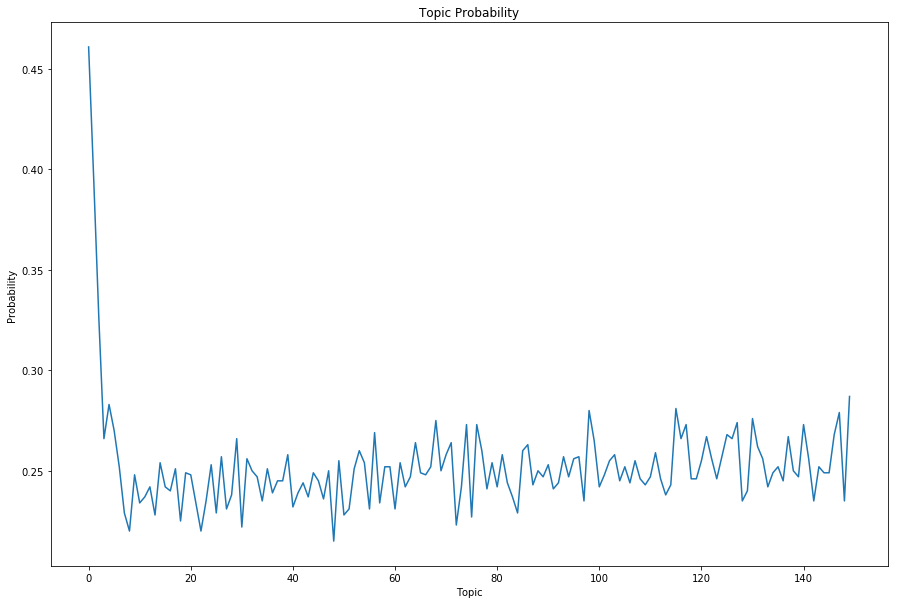

In [84]:
plt.plot(topic_weights['weight'])
plt.title('Topic Probability')
plt.xlabel('Topic')
plt.ylabel('Probability')

In [20]:
hdpmodel.show_topics()

[(0,
  '0.019*trump + 0.015*said + 0.008*president + 0.005*would + 0.004*also + 0.004*white_house + 0.004*republican + 0.004*one + 0.004*story + 0.003*may + 0.003*state + 0.003*time + 0.003*advertisement_continue + 0.003*official + 0.003*reading_main + 0.003*say + 0.003*could + 0.002*people + 0.002*campaign + 0.002*new'),
 (1,
  '0.014*trump + 0.012*said + 0.005*president + 0.004*would + 0.004*one + 0.004*also + 0.003*republican + 0.003*may + 0.003*state + 0.003*story + 0.003*say + 0.003*democrat + 0.003*time + 0.003*people + 0.003*advertisement_continue + 0.002*could + 0.002*reading_main + 0.002*election + 0.002*percent + 0.002*white_house'),
 (2,
  '0.011*trump + 0.009*said + 0.005*story + 0.005*advertisement_continue + 0.005*president + 0.005*reading_main + 0.004*would + 0.002*one + 0.002*may + 0.002*official + 0.002*also + 0.002*white_house + 0.002*united_state + 0.002*report + 0.002*could + 0.002*time + 0.002*american + 0.002*campaign + 0.002*city + 0.001*republican'),
 (3,
  '0.0

In [21]:
hdptopics = hdpmodel.show_topics(formatted=False)

### Topic modeling using [LDA](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf)
This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. To understand it better you can watch [this](https://www.youtube.com/watch?v=DDq3OVp9dNA) lecture by David Blei. Let's choose 10 topics to initialize this.

In [85]:
chunksize = 10000
passes = 20         # Was 20
iterations = 400     # Was 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

ldamodel = LdaModel(corpus=corpus, num_topics=40, id2word=dictionary, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, \
                       passes=passes, eval_every=eval_every)

In [293]:
import pickle
filename = 'lda_model.pkl'
pickle.dump(ldamodel, open(filename, 'wb'))

In [295]:
with open('lda_model.pkl', 'rb') as f:
    ldamodel = pickle.load(f)

pyLDAvis is a great way to visualize an LDA model. To summarize in short, the area of the circles represent the prevelance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. pyLDAvis is based on [this](http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) paper.

In [86]:
import pyLDAvis.gensim

In [87]:
pyLDAvis.enable_notebook()

In [88]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
28     10.701303        1       1 -0.014356  0.052679
22      5.494177        1       2 -0.114309 -0.090718
37      4.669463        1       3  0.178665 -0.012665
29      4.527713        1       4 -0.126606 -0.045908
12      4.401479        1       5  0.007188  0.145738
27      4.159577        1       6 -0.071980  0.065238
38      4.153494        1       7 -0.026681 -0.014724
25      4.119509        1       8 -0.089003  0.018588
21      4.106382        1       9  0.023353  0.020098
16      3.426603        1      10  0.105863 -0.075328
0       3.291785        1      11  0.153161 -0.074379
2       3.133944        1      12 -0.105597 -0.052916
36      3.121354        1      13 -0.086463  0.033263
5       3.079196        1      14 -0.022537 -0.031246
33      2.491403        1      15  0.025000 -0.014517
4       2.424478        1      16  0.082743 -0.037661
34      2.312987        1      17  0.151631  0.045511
13      2.219035        1      18 -0.024679 -0.133651
24      2.214139        1      19  0.158544 -0.117050
11      2.168135        1      20 -0.048255 -0.092752
14      2.141104        1      21  0.043300  0.081903
32      2.139231        1      22  0.046123  0.120983
8       2.052291        1      23  0.018896  0.057416
7       1.891047        1      24 -0.001980  0.008043
30      1.609233        1      25 -0.022246  0.052930
9       1.504422        1      26 -0.016534 -0.085162
10      1.485821        1      27 -0.030641 -0.022054
39      1.334235        1      28 -0.015114  0.086818
17      1.260699        1      29 -0.066694 -0.014097
18      1.136290        1      30  0.041760  0.031321
3       1.073092        1      31  0.015814  0.054231
6       1.013086        1      32 -0.054405  0.010640
19      0.949363        1      33 -0.046889 -0.030586
15      0.791901        1      34 -0.017299 -0.066240
35      0.700176        1      35 -0.007027  0.050021
31      0.678665        1      36 -0.024620  0.003372
26      0.619491        1      37  0.029046  0.038958
20      0.600930        1      38 -0.033959  0.021867
1       0.556366        1      39  0.002471 -0.004006
23      0.246402        1      40 -0.015684  0.016043, topic_info=     Category         Freq                            Term        Total  \
term                                                                      
6239  Default  2238.000000                      main_story  2238.000000   
4775  Default  2439.000000  advertisement_continue_reading  2439.000000   
312   Default  2106.000000                         percent  2106.000000   
1062  Default  1483.000000                           comey  1483.000000   
1483  Default   677.000000                            city   677.000000   
21    Default  1359.000000                            bill  1359.000000   
148   Default  2705.000000                      republican  2705.000000   
2565  Default   715.000000                       gianforte   715.000000   
1774  Default   972.000000                           flynn   972.000000   
838   Default  1838.000000                   investigation  1838.000000   
553   Default  1293.000000                          budget  1293.000000   
143   Default  2078.000000                        democrat  2078.000000   
822   Default  1625.000000                          russia  1625.000000   
121   Default  2910.000000                           state  2910.000000   
3139  Default   798.000000                         kushner   798.000000   
991   Default  1565.000000                            2017  1565.000000   
3     Default  1205.000000                          senate  1205.000000   
184   Default   878.000000                           woman   878.000000   
204   Default  3486.000000                             may  3486.000000   
445   Default  2756.000000                     white_house  2756.000000   
895   Default  1271.000000             

In [89]:
ldatopics = ldamodel.show_topics(num_topics=40,formatted=False)

In [141]:
ldamodel.show_topics(40)
df['url'][0]

'https://fivethirtyeight.com/features/are-moderate-republicans-really-willing-to-kill-the-senate-health-care-bill/'

### Finding out the optimal number of topics
__Introduction to topic coherence__:
<img src="https://rare-technologies.com/wp-content/uploads/2016/06/pipeline.png">
Topic coherence in essence measures the human interpretability of a topic model. Traditionally [perplexity has been used](http://qpleple.com/perplexity-to-evaluate-topic-models/) to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases. Here's a short blog I wrote explaining topic coherence:
[What is topic coherence?](https://rare-technologies.com/what-is-topic-coherence/)

In [104]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    chunksize = 10000
    passes = 1         # Was 20
    iterations = 50     # Was 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    
    c_v = []
    lm_list = []
    for num_topics in range(5, limit+1, 5):
        print(num_topics)
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, \
                       passes=passes, eval_every=eval_every)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    try:
        # Show graph
        x = range(1, len(c_v)+1)
        labels = range(5, limit+1, 5)
        plt.plot(x, c_v)
        plt.xticks(x, labels)
        plt.xlabel("num_topics")
        plt.ylabel("Coherence score")
        plt.legend(("c_v"), loc='best')
        plt.show()
    except:
        pass
    
    return lm_list, c_v

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80


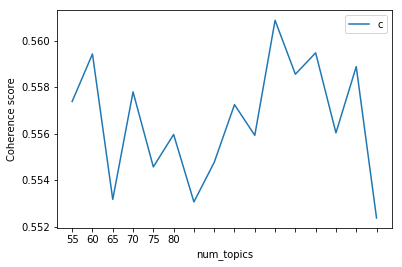

CPU times: user 19min 38s, sys: 23min 34s, total: 43min 12s
Wall time: 22min 13s


In [105]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=80)

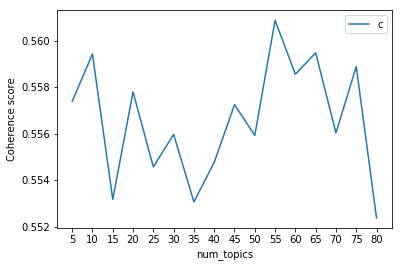

In [106]:
limit = 80
x = range(1, len(c_v)+1)
labels = range(5, limit+1, 5)
plt.plot(x, c_v)
plt.xticks(x, labels)
plt.xlabel("num_topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')
plt.show()

In [107]:
pyLDAvis.gensim.prepare(lmlist[10], corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
53     11.993284        1       1 -0.019684 -0.006217
16      7.118914        1       2 -0.010358 -0.011655
48      5.091387        1       3 -0.020683  0.000718
1       4.622108        1       4 -0.027169  0.001095
20      3.772841        1       5 -0.015850 -0.013362
10      3.664869        1       6 -0.026586  0.007533
18      3.213882        1       7 -0.004500 -0.010977
21      3.189847        1       8 -0.018935  0.017991
30      3.034945        1       9 -0.002728 -0.008692
25      2.798579        1      10 -0.004466 -0.005437
3       2.633842        1      11 -0.026327  0.007751
32      2.594313        1      12 -0.020211 -0.010590
24      2.469689        1      13  0.021256 -0.022633
9       2.315955        1      14 -0.012921 -0.007088
8       2.292694        1      15 -0.013162  0.000689
12      2.250567        1      16  0.014693 -0.025044
43      2.228563        1      17 -0.014668  0.011012
0       2.126463        1      18 -0.005729 -0.001179
28      2.068961        1      19 -0.003681 -0.000863
26      2.040084        1      20 -0.009993  0.000871
6       1.866226        1      21 -0.006905  0.003408
49      1.698903        1      22 -0.001545  0.003908
44      1.644071        1      23  0.013348 -0.019800
31      1.621519        1      24  0.021976 -0.020594
35      1.554227        1      25 -0.007515 -0.008030
36      1.529242        1      26  0.001104 -0.004444
29      1.256473        1      27  0.008279 -0.007754
52      1.170980        1      28 -0.003966  0.000889
2       1.144853        1      29  0.001048  0.000534
23      0.907959        1      30  0.006790 -0.005663
22      0.901468        1      31 -0.000704  0.009209
5       0.881189        1      32 -0.000468 -0.001262
19      0.873542        1      33 -0.004413 -0.001628
50      0.839426        1      34 -0.011420  0.003722
14      0.827238        1      35  0.007577 -0.009029
40      0.818310        1      36  0.018321 -0.011073
45      0.787883        1      37  0.007329  0.001191
46      0.761981        1      38  0.018365 -0.015017
41      0.743081        1      39 -0.021861  0.012566
38      0.739448        1      40 -0.001648  0.007223
39      0.716191        1      41  0.008477 -0.003427
42      0.650365        1      42  0.004659  0.019943
7       0.621341        1      43  0.004363 -0.008574
11      0.562655        1      44  0.003921  0.004426
4       0.537292        1      45  0.002902 -0.000638
13      0.526830        1      46 -0.018700  0.024076
51      0.471254        1      47  0.019299  0.020342
27      0.416009        1      48  0.003513 -0.000608
15      0.330868        1      49  0.003823  0.011683
54      0.328693        1      50  0.018544 -0.012186
47      0.220088        1      51  0.011442  0.009475
37      0.165778        1      52  0.009191  0.016849
17      0.160347        1      53  0.001241  0.024036
33      0.133834        1      54  0.029032 -0.001113
34      0.068646        1      55  0.076302  0.033436, topic_info=      Category          Freq                    Term         Total  loglift  \
term                                                                          
183    Default  18243.000000                   trump  18243.000000  30.0000   
822    Default  13883.000000                    said  13883.000000  29.0000   
5493   Default   7424.000000                      mr   7424.000000  28.0000   
281    Default   8191.000000               president   8191.000000  27.0000   
280    Default   6616.000000                       u   6616.000000  26.0000   
39     Default   6069.000000                   would   6069.000000  25.0000   
136    Default   4115.000000                     one   4115.000000  24.0000   
18450  Default   2661.000000              main_story   2661.000000  23.0000   
48     Default   3977.000000                  people   3977.000000  22.0000   
53     Def

In [30]:
lmtopics = lmlist[5].show_topics(formatted=False)

The following gets the topics that are most like the article inserted

In [90]:
def get_best_topic(model, article_bow, bow=True):
    if not bow:
        article_bow = model.id2word.doc2bow([word for word in article_bow])
    else:
        article_bow = model.id2word.doc2bow(article_bow)
    article_topics = model[article_bow]
    return article_topics

In [91]:
article_topics = []
for article in train_texts:
    article_topics.append(get_best_topic(ldamodel, article, bow=True))
article_topics

[[(11, 0.54807235308468982), (22, 0.45039845930069655)],
 [(9, 0.34604394577691266),
  (27, 0.016238667394842924),
  (29, 0.42604194011330354),
  (33, 0.16986355651528912),
  (36, 0.032262421385644134)],
 [(2, 0.093201523111078211),
  (13, 0.037338920007357619),
  (17, 0.012513316251373009),
  (22, 0.067943212511524562),
  (29, 0.64390938762896666),
  (35, 0.038853334292411869),
  (38, 0.10548286770957407)],
 [(0, 0.10106320686932053),
  (9, 0.21967302677961553),
  (24, 0.027082562651064412),
  (28, 0.48038941974690985),
  (33, 0.16022371447720135)],
 [(6, 0.3195917440573619),
  (9, 0.10654828463943523),
  (28, 0.41507707190141002),
  (29, 0.015043594312853381),
  (33, 0.14340997344726833)],
 [(2, 0.15798706420515912),
  (6, 0.040389119574286224),
  (8, 0.33987172682872152),
  (29, 0.088157353072992772),
  (38, 0.37257611449070133)],
 [(2, 0.04665443823896135),
  (16, 0.041575871746348768),
  (22, 0.45425040014298085),
  (28, 0.027289500059425993),
  (29, 0.22394482597984011),
  (33, 0

<Container object of 40 artists>

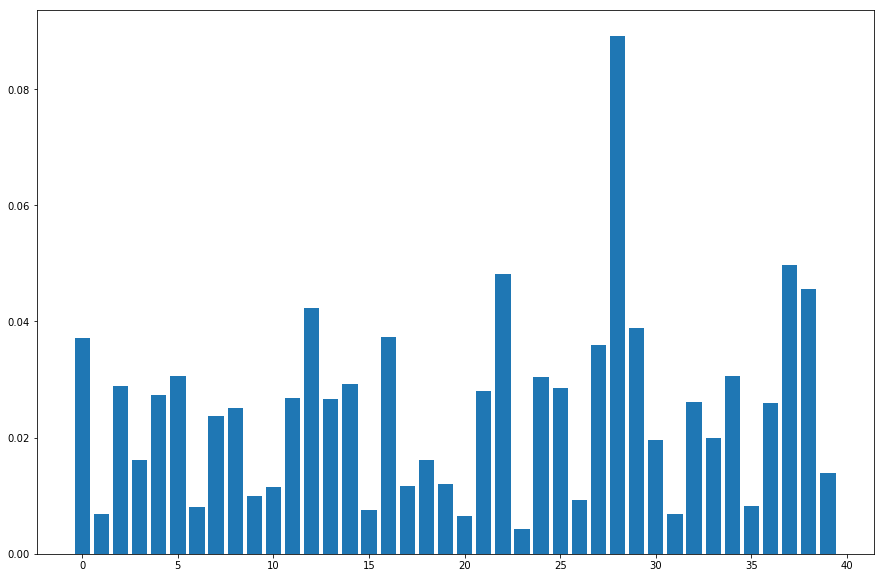

In [92]:
topic_coverage = [0 for topic in range(40)]
for article_topic in article_topics:
    for coverage in article_topic:
        topic_coverage[coverage[0]] += coverage[1]
topic_coverage = topic_coverage/sum(topic_coverage)

import matplotlib.pyplot as plt
plt.bar(range(40), topic_coverage)
# ldatopics[np.argsort(topic_coverage)[::-1][2]]

Now I will perform sentiment analysis

In [93]:
import nltk
from nltk.corpus import sentiwordnet as swn

In [94]:
def get_sentiment(word):
    mean_pos = 0
    mean_neg = 0
    mean_obj = 0
    score = 0
    bias = 0
    for similar_words in swn.senti_synsets(word):
        mean_pos += similar_words.pos_score()
        mean_neg += similar_words.neg_score()
        mean_obj += similar_words.obj_score()
    size = len(list(swn.senti_synsets(word)))
    if size != 0:
        mean_pos = mean_pos/size
        mean_neg = mean_neg/size
        mean_obj = mean_obj/size
        score = (mean_pos - mean_neg)*(1-mean_obj)
        bias = (mean_pos + mean_neg) * (1-mean_obj)
    return mean_pos, mean_neg, mean_obj, score, bias

In [132]:
ldatopics = ldamodel.show_topics(num_topics=-1, num_words=10000,formatted=False)
relevant_types = ['JJ', 'VB', 'RB'] #adjectives, verbs, adverbs
words = []
for word_and_prob in ldatopics[0][1]:
    word = word_and_prob[0]
    for word, word_type in nltk.pos_tag([word]):
        if word_type in relevant_types:
            words.append(word)
len(words)

763

In [131]:
sentiment_texts_words = set()
for i in range(len(sentiment_texts)):
    sentiment_texts_words = sentiment_texts_words | set(sentiment_texts[i])
sentiment_texts_words = list(sentiment_texts_words)
len(sentiment_texts_words)

42625

In [133]:
sentiment_of_words = dict()
for word in sentiment_texts_words:
    if word in words:
        pos, neg, obj, score, bias = get_sentiment(word)
        if pos == 0 and neg == 0:
            pass
        else:
            sentiment_of_words[word] = [pos, neg, obj, score, bias]
sentiment_words = list(sentiment_of_words.keys())
# print(list(sentiment_of_words.keys())[0], sentiment_of_words[list(sentiment_of_words.keys)[0]])
len(sentiment_words)

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


531

In [135]:
sentiment_by_article_without_prob = []
for i, article_topic in enumerate(article_topics):
    print(i)
    sentiment_by_topic = dict()
    max_prob = 0
    for topic_and_prob in article_topic:
        topic = topic_and_prob[0]
        topic_prob = topic_and_prob[1]
        s_pos = 0
        s_neg = 0
        s_obj = 0
        s_score = 0
        s_bias = 0
        relevant_word_count = 0
        for words_and_probs in ldatopics[topic][1]:
            word = words_and_probs[0]
            if word in sentiment_words and word in train_texts[i]:
                relevant_word_count += 1
                prob = words_and_probs[1]
                if prob > max_prob:
                    max_prob = prob
                pos, neg, obj, score, bias = sentiment_of_words[word]
                s_pos += pos
                s_neg += neg
                s_obj += obj
                s_score += score * prob #weight word depending on prob for that topic
                s_bias += bias * prob
        if relevant_word_count != 0:
            sentiment_by_topic[topic] = [topic_prob, max_prob, s_pos/relevant_word_count, s_neg/relevant_word_count, s_obj/relevant_word_count, s_score/relevant_word_count]
    sentiment_by_article_without_prob.append(sentiment_by_topic)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [231]:
len(ldatopics)

40

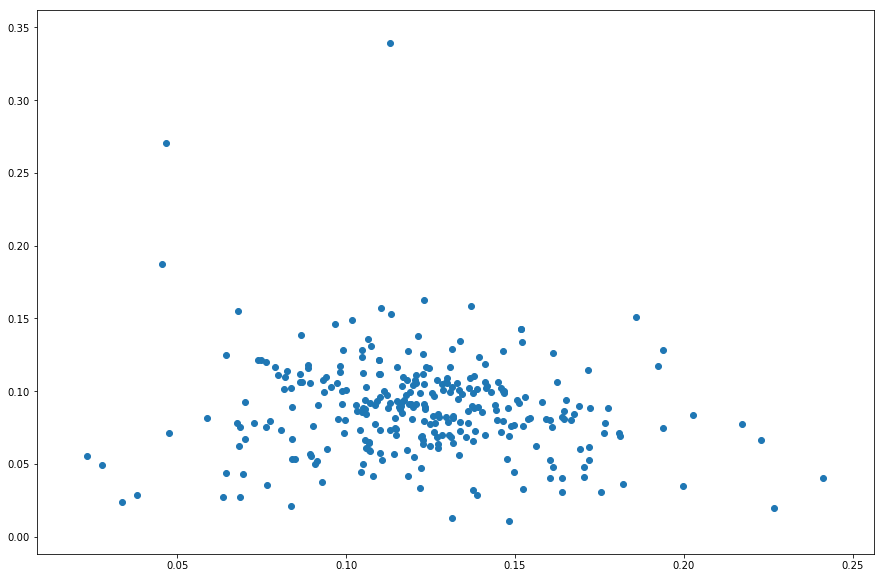

In [287]:
for topic in [27]:
    x = []
    y = []
    site_url = []
    site_source = []
    topic_prob = []
    for i, sentiment_by_topic in enumerate(sentiment_by_article_without_prob):
        if topic in sentiment_by_topic:
            if sentiment_by_topic[topic][0] > 0.1:
                min_prob = sentiment_by_topic[topic][1]
                x.append(sentiment_by_topic[topic][2])
                y.append(sentiment_by_topic[topic][3])
                site_url.append(df['url'][i])
                site_source.append(df['source'][i])
                topic_prob.append(sentiment_by_topic[topic][0])
    plt.scatter(x, y)

### Now work on Bokeh

In [291]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool, WheelZoomTool, HoverTool, LassoSelectTool, PanTool
from bokeh.plotting import figure, output_file, show

output_file("openurl.html")

from bokeh.io import output_notebook
output_notebook()

    
hover = HoverTool(
    tooltips=[
        ("source", "@site"),
        ("(pos,neg)", "($x, $y)"),
    ]
)

p = figure(plot_width=1200, plot_height=800,
            tools=["tap, pan, wheel_zoom",hover], title="Click the Dots",
          toolbar_location="right")

# p.toolbar.active_drag = 'auto'

a = 0.9
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0,100,0), (0, 0, 0), (100, 25, 200), (255, 255, 0), (0, 255, 255), (255, 0, 255), (128, 128, 128), (0, 0, 128), (240,230,140)]
sources = ['cnn', 'abc', 'fox', 'nyt', 'reuters', 'wapo', 'huffpo', 'esquire', 'rollingstone', 'cbs', '538', 'washtimes']

pos_by_site = {site: [] for site in sources}
neg_by_site = {site: [] for site in sources}
size_by_site = {site: [] for site in sources}
url_by_site = {site: [] for site in sources}
for site in sources:
    indices = [j for j, t in enumerate(site_source) if t == site]
    if indices == []:
        print('Not: '+site)
    else:
        pos_by_site[site] = np.array(x)[indices]
        neg_by_site[site] = np.array(y)[indices]
        size_by_site[site] = [50*topic for topic in np.array(topic_prob)[indices]]
        url_by_site[site] = np.array(site_url)[indices]

import seaborn.apionly as sns
import itertools 
ncolors = len(sources)
palette = sns.palettes.color_palette('colorblind', ncolors)
# as hex is necessary for bokeh to render the colors properly.

for site, color in zip(sources, colors):
    source = ColumnDataSource(data=dict(
        x=pos_by_site[site],
        y=neg_by_site[site],
#         color=["navy", "orange", "olive", "firebrick", "gold"],
        size=size_by_site[site],
        site=[site for i in range(len(pos_by_site[site]))],
        url=url_by_site[site]
    ))

    p.circle('x', 'y', color=color, alpha=a, size='size', source=source, legend=site)

    url = "@url"
    taptool = fig.select(type=TapTool)
    taptool.callback = OpenURL(url=url)
    
show(p)

INFO:bokeh.core.state:Session output file 'openurl.html' already exists, will be overwritten.


Loading BokehJS ...

Not: cnn


AttributeError: 'list' object has no attribute 'references'

In [192]:
help(figure)

Help on function figure in module bokeh.plotting.figure:

figure(**kwargs)
    Create a new :class:`~bokeh.plotting.figure.Figure` for plotting.
    
    In addition to the standard :class:`~bokeh.plotting.figure.Figure`
    property values (e.g. ``plot_width`` or ``sizing_mode``) the following
    additional options can be passed as well:
    
    .. bokeh-options:: FigureOptions
        :module: bokeh.plotting.figure
    
    Returns:
       Figure



### Now work on Plotly

In [ ]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode, plot, iplot

In [ ]:
a = 0.9
colors = ['rgba(255, 0, 0, '+str(a)+')', 'rgba(0, 255, 0, '+str(a)+')', 'rgba(0, 0, 255, '+str(a)+')', 'rgba(255, 255, 255, '+str(a)+')', 'rgba(0, 0, 0, '+str(a)+')', 'rgba(, , , '+str(a)+')', 'rgba(255, 255, 0, '+str(a)+')', 'rgba(0, 255, 255, '+str(a)+')', 'rgba(255, 0, 255, '+str(a)+')', 'rgba(128, 128, 128, '+str(a)+')', 'rgba(0, 0, 128, '+str(a)+')', 'rgba(128, 0, 128, '+str(a)+')']
sources = ['cnn', 'abc', 'fox', 'nyt', 'reuters', 'wapo', 'huffpo', 'esquire', 'rollingstone', 'cbs', '538', 'washtimes']

traces = []
for i, site in enumerate(sources):
    indices = [j for j, t in enumerate(source) if t == site]
    if indices == []:
        print('Not: '+site)
    else:
        print(site)
        trace = go.Scatter(
            x = np.array(x)[indices],
            y = np.array(y)[indices],
            name = site,
#           text = ['<a href=\{0}>link to article</a>'.format(link) for link in np.array(url)[indices]],
            mode = 'markers',
            marker = dict(
                size = [50*topic for topic in np.array(topic_prob)[indices]],
                color = colors[i],
                line = dict(
                    width = 1,
                )
            )
        )
        traces.append(trace)

# plotAnnotes = []

# plotAnnotes.append(dict(x=x,
#                         y=y,
#                         text=['<a href="{0}">link to article</a>'.format(link) for link in url],
#                         showarrow=False,
#                         xanchor='center',
#                         yanchor='center',
#                         ))
# layout = go.Layout(
#     showlegend=True,
#     annotations=plotAnnotes
# )
data = [trace for trace in traces]
fig = go.Figure(data=data)#, layout=layout)


# Plot and embed in ipython notebook!  
plotly.offline.init_notebook_mode()
from plotly.offline import iplot                                                                                                                                                                        
# plotly_url = plotly.offline.plot(fig, filename='basic-scatter.html', auto_open=True)
# plotly_url = iplot(fig)

from plotly.widgets import GraphWidget
import pathlib
url = pathlib.Path('/home/ian/Galvanize/news_bias/working_with_data/basic-scatter.html').as_uri()

# graph = GraphWidget(HTML(filename='/home/ian/Galvanize/news_bias/working_with_data/basic-scatter.html'))
graph = GraphWidget(url)
g = graph
from IPython.display import display
display(graph)
# print(HTML(filename='/home/ian/Galvanize/news_bias/working_with_data/basic-scatter.html'))
from IPython.display import Image
from IPython.display import HTML
# display(HTML(filename='/home/ian/Galvanize/news_bias/working_with_data/basic-scatter.html'))
def message_handler(widget, msg):
    clear_output()
    print(idget._graph_url)
    display(msg)

g.on_click(message_handler)
# help(GraphWidget)

# from ipywidgets import Output
# plotly.offline.init_notebook_mode()
# ow = Output()
# with ow:
#     plotly.offline.plot(fig, filename='basic-scatter.html')
# ow


In [440]:
import plotly
from plotly.graph_objs import graph_objs as go
from IPython.html.widgets import interact

plotly.offline.init_notebook_mode()
from plotly.offline import iplot
def view_image(w):
    x_data = [1,2,3]
    x1 = [i+w for i in x_data]
    fig1 = go.Scatter(x=x1,y=[4,5,6])
    fig2 = go.Scatter(x=x_data,y=[4,5,6])
    iplot(data)
interact(view_image, w=(0,100))

In [381]:
def message_handler(widget, msg):
    clear_output()
    print(idget._graph_url)
    display(msg)
    
g.on_click(message_handler)
# help(GraphWidget)
print(g)

### Word Clouds

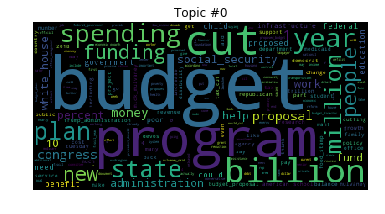

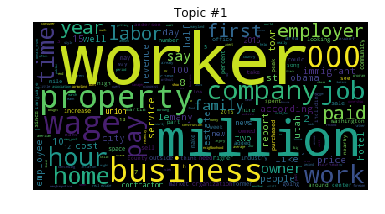

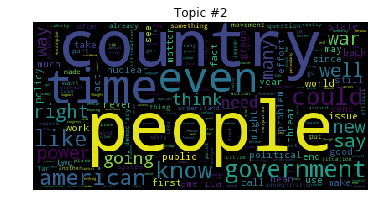

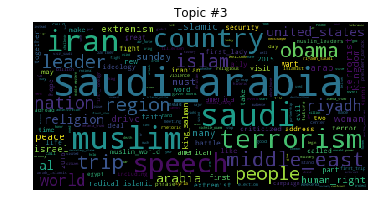

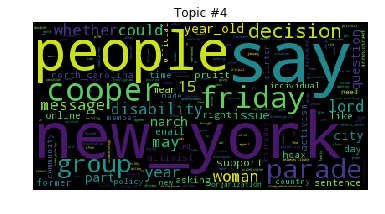

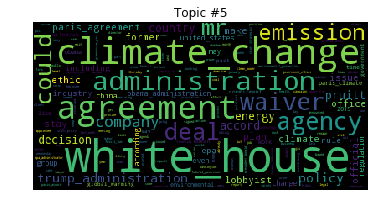

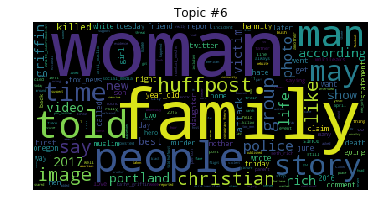

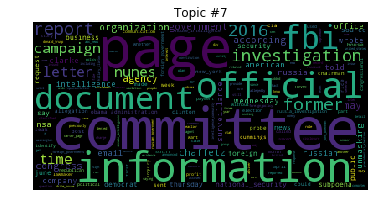

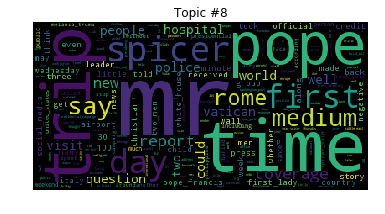

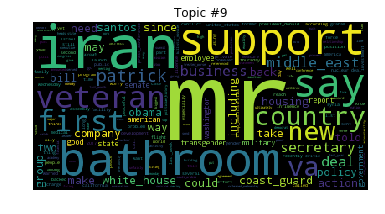

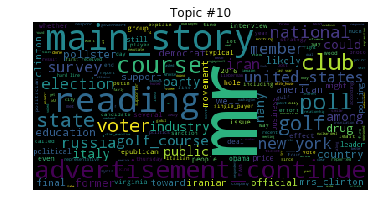

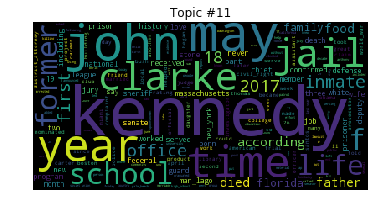

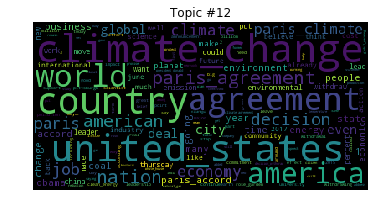

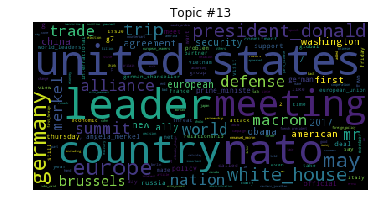

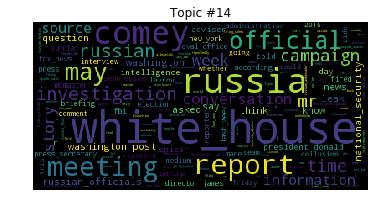

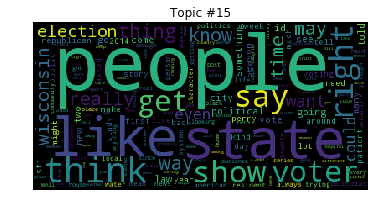

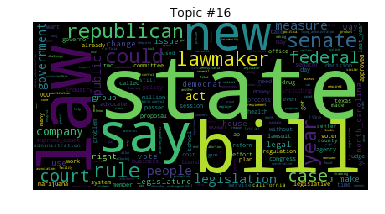

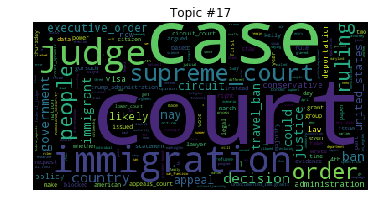

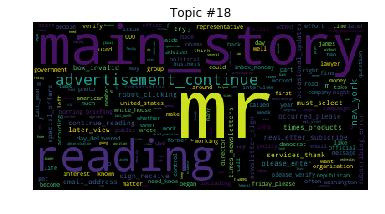

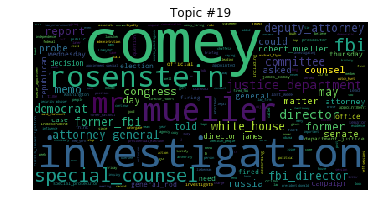

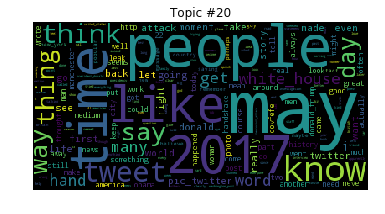

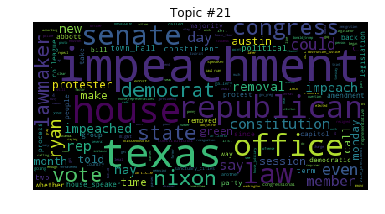

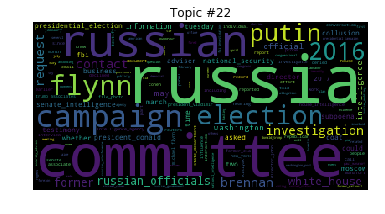

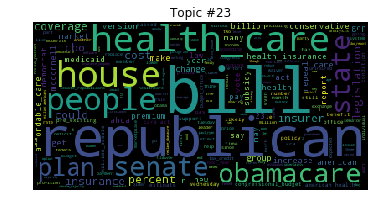

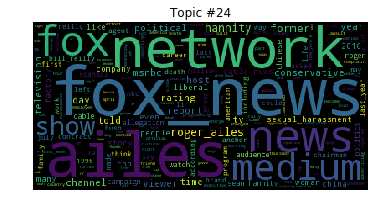

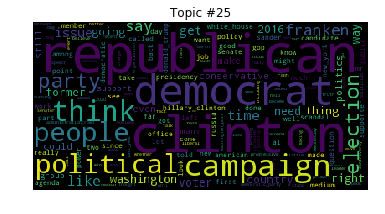

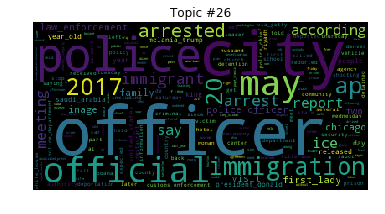

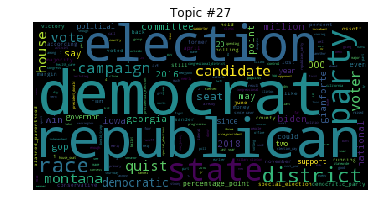

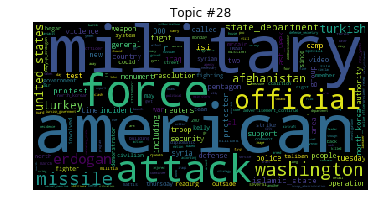

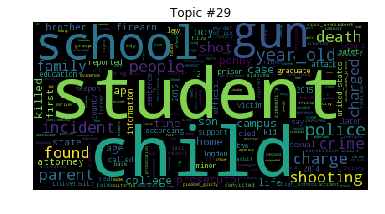

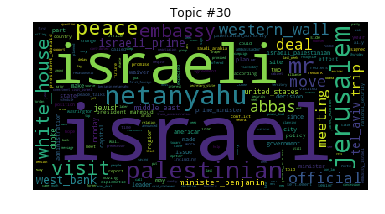

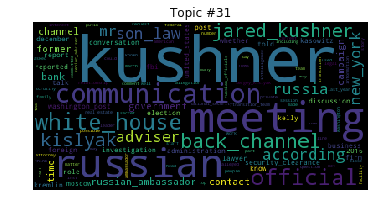

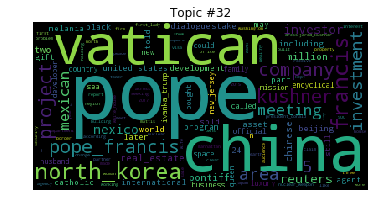

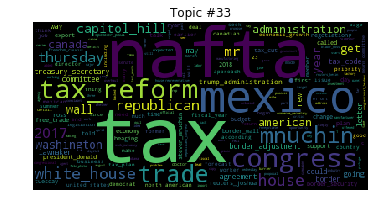

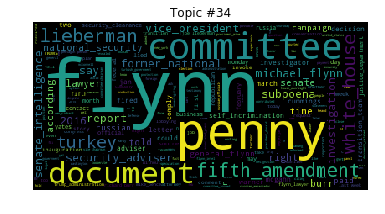

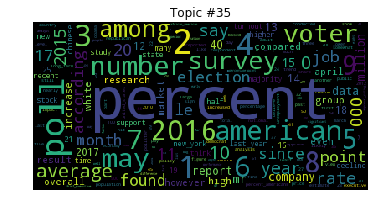

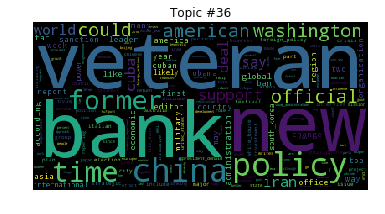

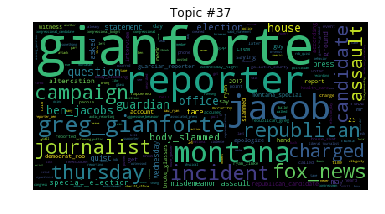

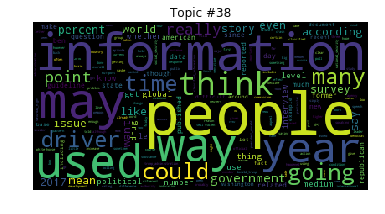

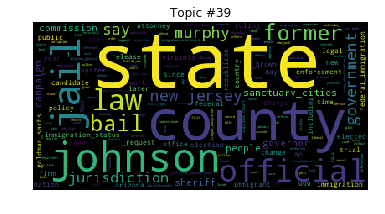

In [399]:
from wordcloud import WordCloud
for t in range(ldamodel.num_topics):
    topic_dict = dict()
    for word_prob in ldatopics[t][1]:
        topic_dict[word_prob[0]] = word_prob[1]
    plt.figure()
    plt.imshow(WordCloud().fit_words(topic_dict))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

### LDA as LSI

One of the problem with LDA is that if we train it on a large number of topics, the topics get "lost" among the numbers. Let us see if we can dig out the best topics from the best LDA model we can produce. The function below can be used to control the quality of the LDA model we produce.

In [112]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    chunksize = 10000
    passes = 1         # Was 20
    iterations = 50     # Was 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    num_topics = 40
    top_topics = [(0, 0)]
    
    while top_topics[0][1] < 0.70:
        print(top_topics[0][1])
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, \
                       passes=passes, eval_every=eval_every)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [113]:
lm, top_topics = ret_top_model()

0
0.43380315042


KeyboardInterrupt: 

In [ ]:
print(top_topics[:5])

### Inference
We can clearly see below that the first topic is about __cinema__, second is about __email malware__, third is about the land which was given back to the __Larrakia aboriginal community of Australia__ in 2000. Then there's one about __Australian cricket__. LDA as LSI has worked wonderfully in finding out the best topics from within LDA.

In [78]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[(u'actor', 0.034688196735986693),
  (u'picture', 0.023163878883499418),
  (u'award', 0.023163878883499418),
  (u'comedy', 0.023163878883499418),
  (u'globe', 0.023163878883499418),
  (u'nomination', 0.023163878883499418),
  (u'actress', 0.023163878883499418),
  (u'film', 0.023163878883499418),
  (u'drama', 0.011639561031012149),
  (u'winner', 0.011639561031012149)],
 [(u'virus', 0.064292949289013482),
  (u'user', 0.048074573973209883),
  (u'computer', 0.040350900997751814),
  (u'company', 0.028173623478117912),
  (u'email', 0.022580226976870982),
  (u'worm', 0.020928236506996975),
  (u'attachment', 0.014534311779706417),
  (u'outlook', 0.01260706654637953),
  (u'software', 0.011909411409069969),
  (u'list', 0.0088116041533348403)],
 [(u'claim', 0.0096511365969504694),
  (u'agreement', 0.0082836950379963047),
  (u'hectare', 0.0077564979304569235),
  (u'larrakia', 0.0065928813973845394),
  (u'rosebury', 0.006086042494624749),
  (u'term', 0.004880655853124416),
  (u'region', 0.004786636

In [98]:
lda_lsi_topics = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

### Evaluating all the topic models
Any topic model which can come up with topic terms can be plugged into the coherence pipeline. You can even plug in an [NMF topic model](http://derekgreene.com/nmf-topic/) created with scikit-learn.

In [99]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

In [100]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lm_coherence = CoherenceModel(topics=lmtopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_lsi_coherence = CoherenceModel(topics=lda_lsi_topics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

In [101]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

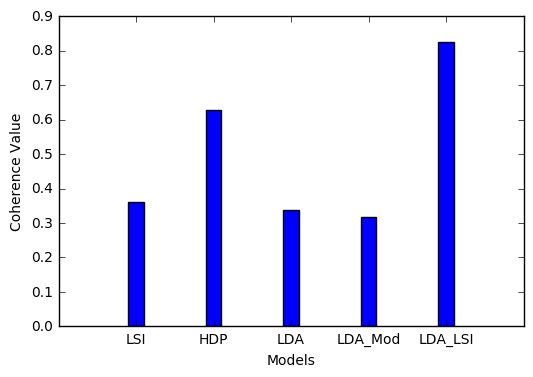

In [102]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, lda_lsi_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_Mod', 'LDA_LSI'])

### Customizing the topic coherence measure
Till now we only used the `c_v` coherence measure. There are others such as `u_mass`, `c_uci`, `c_npmi`. All of these calculate coherence in a different way. `c_v` is found to be most in line with human ratings but can be much slower than `u_mass` since it uses a sliding window over the texts.

### Making your own coherence measure
Let's modify `c_uci` to use `s_one_pre` instead of `s_one_one` segmentation

In [47]:
from gensim.topic_coherence import (segmentation, probability_estimation,
                                    direct_confirmation_measure, indirect_confirmation_measure,
                                    aggregation)
from gensim.matutils import argsort
from collections import namedtuple

In [48]:
make_pipeline = namedtuple('Coherence_Measure', 'seg, prob, conf, aggr')

In [49]:
measure = make_pipeline(segmentation.s_one_one,
                        probability_estimation.p_boolean_sliding_window,
                        direct_confirmation_measure.log_ratio_measure,
                        aggregation.arithmetic_mean)

To get topics out of the topic model:

In [50]:
topics = []
for topic in lm.state.get_lambda():
    bestn = argsort(topic, topn=10, reverse=True)
topics.append(bestn)

__Step 1__: Segmentation

In [51]:
# Perform segmentation
segmented_topics = measure.seg(topics)

__Step 2__: Probability estimation

In [52]:
# Since this is a window-based coherence measure we will perform window based prob estimation
per_topic_postings, num_windows = measure.prob(texts=train_texts, segmented_topics=segmented_topics,
                                               dictionary=dictionary, window_size=2)

__Step 3__: Confirmation Measure

In [53]:
confirmed_measures = measure.conf(segmented_topics, per_topic_postings, num_windows, normalize=False)

__Step 4__: Aggregation

In [54]:
print(measure.aggr(confirmed_measures))

-11.2873225334


# How this topic model can be used further
The best topic model here can be used as a standalone for news article classification. However a topic model can also be used as a dimensionality reduction algorithm to feed into a classifier. A good topic model should be able to extract the signal from the noise efficiently, hence improving the performance of the classifier.